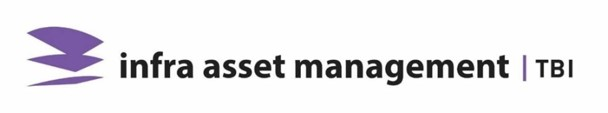

Deze notebook word gebruikt voor het opbouwen an de verschillende grafieken die geëxporteerd moeten worden als PDF om deze bij te voegen als bijlage aan de storingsanalse.

# Importeren van de benodigdheden

## Python packages 

In [1]:
import os
import json
import asyncio

import pandas as pd

import ipywidgets as widgets 
from ipywidgets import interact, interact_manual, Layout

import time
from datetime import datetime

from storingsanalyse import StoringsAnalyse

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Class zorgt ervoor dat een waarde meegegeven kan worden aan een Button
import traitlets
class LoadedButton(widgets.Button):
    """A button that can holds a value as a attribute."""

    def __init__(self, value=None, *args, **kwargs):
        super(LoadedButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))


# Aparte functie voor het wachten op verandering (aka input van de ME)
def wait_for_change(widget):
    future = asyncio.Future()
    def getvalue(change):
        future.set_result(change.description)
        widget.on_click(getvalue, remove=True) 
        # we need to free up the binding to getvalue to avoid an InvalidState error
        # buttons don't support unobserve
        # so use `remove=True` 
    widget.on_click(getvalue)
    return future

In [3]:
""" In the line bellow fill in your API key without < and > """ 
api_key = 'bWF4YWRtaW46R21iQ1dlbkQyMDE5' # provided to you by a Maximo Consultant

""" In the line bellow fill in the desired object structure """
obj_struct = 'MXWO_SND' # name of the Maximo object structure

""" In the line bellow fill in the PO number and the SITEID without the < and > """
query = 'siteid="CT1EN2" and worktype="COR" and reportdate>="2018-01-01T00:00:00-00:00" and reportdate<="2018-03-30T00:00:00-00:00"'

In [4]:
sa = StoringsAnalyse("coentunnel", api_key, obj_struct)

In [5]:
sa.metadata.get_all_data()

,project,start_datum,contract_info,meldingen,storingen
0,Coentunnel-tracé,01_2016,"{'tijdsregistratie': 'True', 'minimale_beschik...","{'01_2016': {'45': 6, '61': 5, '23': 1, '43': ...","{'01_2016': {'61': 3, '43': 2, '45': 3, '41': ..."


## Importeren van de staging_file

De staging file geeft ruimte aan de maintenance engineers om de verschillende meldingen te categoriseren als 'Onterecht', 'Preventief', 'Storing' of 'Incident'.

In [6]:
sa.read_staging_file('staging_file.xlsx')

In [7]:
sf_data = sa.staging_file_data

### Aanpassen van de staging_file -- DEZE STAP WORDT VERWIJDERD IN DE TOEKOMST
Het opbouwen van deze automatische storingsanalyse vraagt om een ingevulde kolom 'type melding'. Om het process van opbouwen niet te laten stagneren op dit aspect, wordt er hieronder fictive data gegenereerd. Met behulp van de fictieve data wordt het genereren van de verschillende tabellen en grafieken gebouwd.

In [8]:
from random import randrange

lijst_opties = ['Storing', 'Incident', 'Preventief', 'Onterecht']

random_ranges = [lijst_opties[randrange(0, 4, 1)] for _ in range(len(sf_data['type melding (Storing/Incident/Preventief/Onterecht)']))]

print(len(random_ranges) == len(sf_data['type melding (Storing/Incident/Preventief/Onterecht)']))

sf_data.loc[:, 'type melding (Storing/Incident/Preventief/Onterecht)'] = random_ranges

random_ranges[:10]

True


['Incident',
 'Storing',
 'Onterecht',
 'Onterecht',
 'Onterecht',
 'Onterecht',
 'Onterecht',
 'Storing',
 'Onterecht',
 'Onterecht']

In [9]:
import numpy as np
lijst_opties = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', np.nan]

random_ranges = [lijst_opties[randrange(0, len(lijst_opties), 1)] for _ in range(len(sf_data['probleem code']))]

print(len(random_ranges) == len(sf_data['probleem code']))

sf_data.loc[:, 'probleem code'] = random_ranges

random_ranges[:10]

True


['P06', 'P09', 'P03', 'P10', 'P07', 'P02', 'P08', 'P07', 'P06', 'P09']

In [10]:
lijst_opties = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 
                'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', np.nan]

random_ranges = [lijst_opties[randrange(0, len(lijst_opties), 1)] for _ in range(len(sf_data['oorzaak code']))]

print(len(random_ranges) == len(sf_data['oorzaak code']))

sf_data.loc[:, 'oorzaak code'] = random_ranges

random_ranges[:10]

True


['C02', 'C10', 'C03', 'C09', 'C08', 'C01', 'C10', 'C08', 'C04', 'C05']

In [11]:
lijst_opties = ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', np.nan]

random_ranges = [lijst_opties[randrange(0, len(lijst_opties), 1)] for _ in range(len(sf_data['oplos code']))]

print(len(random_ranges) == len(sf_data['oplos code']))

sf_data.loc[:, 'oplos code'] = random_ranges

random_ranges[:10]

True


['S03', 'S04', 'S07', nan, 'S01', 'S01', 'S08', 'S02', 'S04', 'S03']

In [12]:
sf_data.iloc[:5, 15:25]

,locatie 2,locatie 2 omschrijving,probleem code,beschrijving probleem,oorzaak code,beschrijving oorzaak,oplos code,oplossing beschrijving,uitgevoerde werkzaamheden,type melding (Storing/Incident/Preventief/Onterecht)
0,NaN,NaN,P06,Lussen vermoedelijk vekeerd om aangesloten,C02,Davinci,S03,NaN,Storing ontvangen op 4 januari 2018 om 15:28 g...,Incident
1,NaN,NaN,P09,Intercom installatie niet beschikbaar,C10,NaN,S04,NaN,Storing ontvangen op 6 januari 2018 om 0:23 ge...,Storing
2,NaN,NaN,P03,Overdruk ruimte pompkelder niet aanwezig,C03,Vorst bewaking,S07,NaN,Storing ontvangen op 6 juniari 2018 om 20:18 g...,Onterecht
3,NaN,NaN,P10,Geen overdruk aanwezig pompkelders CT1,C09,NaN,NaN,NaN,Storing ontvangen op 7 januari 2018 om 7:50 ge...,Onterecht
4,NaN,NaN,P07,Afsluitboom Noord W2 rechts melding niet besch...,C08,NaN,S01,NaN,Storing ontvangen op 8 januari 2018 om 17:10 g...,Onterecht


# Grafieken
het opbouwen van de vershcillende grafiek wordt gedaan in twee codeblokken; een prep blok en een plot blok. prep doelt hier op het voorberijden van de data en plot zegt het al.

In [13]:
sa.split_staging_file()

'Data available through the use of StoringsAnalyse.meldingen and StoringsAnalyse.storingen'

## Aantal meldingen per deelinstallatie

In [14]:
df = sf_data.copy()
# changing the di_numbers from '45-10' to '45'
new_num = []
for num in df['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

df.loc[:, 'sbs'] = new_num

In [15]:
# prep
sbs_grouped_df = df.copy().groupby(['sbs'])

"""
dictionary structure
{'23': {1: 1},
 '41': {1: 1},
 '43': {2: 1},
 '45': {2: 2, 1: 2},
 '46A': {2: 2},
 '61': {3: 1},
 '62': {1: 1},
 '63': {1: 1},
 '67': {2: 1},
 '74': {2: 1}}
"""
dictionary = {}
for group in sbs_grouped_df.groups.keys():
    df_group = sbs_grouped_df.get_group(group)
    month_counts = df_group['month_number'].value_counts().to_dict()
    if group in dictionary:
        for key in group.keys():
            if key in dictionary[group]:
                dictionary[group][key] += group[key]
            else:
                dictionary[group] = group[key]
    else:
        dictionary[group] = month_counts

"""
new_dictionary structure
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
new_dictionary = {}
for di_num in dictionary:
    list_of_lists = []
    for i in range(3):
        month_num = i + 1
        if month_num in dictionary[di_num].keys():
            list_of_lists.append(dictionary[di_num][month_num])
        else:
            list_of_lists.append(0)
    new_dictionary[di_num] = list_of_lists

"""
lol structure
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(3):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)  

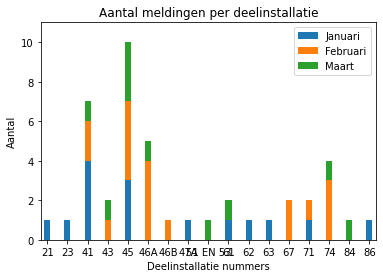

In [16]:
# plot
labels = list(new_dictionary.keys())
width = 0.3

fig, axis = plt.subplots()

prev = []
for l in range(len(lol)):
    month = sa._month_num_to_name([l+1])

    # added case for loop l = 0 after if
    axis.bar(labels, lol[l], width, label=month, bottom=prev) if l > 0 else \
    axis.bar(labels, lol[l], width, label=month)
    
    # prev sets the height of the newly added values like above
    # the added list needs to be added to prev to get the correct height
    prev = [prev[idx] + lol[l][idx] for idx in range(len(lol[l]))] if l > 0 else lol[l]

axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen per deelinstallatie")
axis.legend()

axis.margins(x=0.01, y=0.1)

plt.show()

{'Januari': 30, 'Februari': 45, 'Maart': 24}


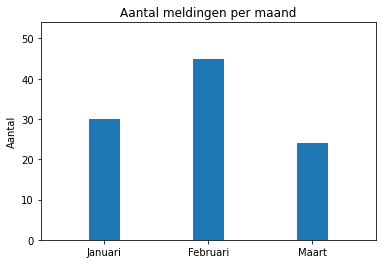

In [17]:
# prep
val_counts_months = df['month_number'].value_counts()

ordered_dict = {key: val_counts_months[key] for key in sorted(val_counts_months.to_dict())}

for key in ordered_dict.keys():
    new_key = sa._month_num_to_name([key])
    ordered_dict[new_key] = ordered_dict.pop(key)

print(ordered_dict)

# plot
fig, axis = plt.subplots()
axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)
axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen per maand")
axis.margins(x=.2, y=.2)
plt.show()

## Aantal storingen per deelinstallatie

In [18]:
df_s = sa.storingen.copy()
# changing the di_numbers from '45-10' to '45'
new_num = []
for num in df_s['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

df_s.loc[:, 'sbs'] = new_num

In [19]:
# prep
sbs_grouped_df = df_s.copy().groupby(['sbs'])

"""
dictionary structure
{'23': {1: 1},
 '41': {1: 1},
 '43': {2: 1},
 '45': {2: 2, 1: 2},
 '46A': {2: 2},
 '61': {3: 1},
 '62': {1: 1},
 '63': {1: 1},
 '67': {2: 1},
 '74': {2: 1}}
"""
dictionary = {}
for group in sbs_grouped_df.groups.keys():
    df_group = sbs_grouped_df.get_group(group)
    month_counts = df_group['month_number'].value_counts().to_dict()
    if group in dictionary:
        for key in group.keys():
            if key in dictionary[group]:
                dictionary[group][key] += group[key]
            else:
                dictionary[group] = group[key]
    else:
        dictionary[group] = month_counts

"""
new_dictionary structure
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
new_dictionary = {}
for di_num in dictionary:
    list_of_lists = []
    for i in range(3):
        month_num = i + 1
        if month_num in dictionary[di_num].keys():
            list_of_lists.append(dictionary[di_num][month_num])
        else:
            list_of_lists.append(0)
    new_dictionary[di_num] = list_of_lists

"""
lol structure
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(3):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)

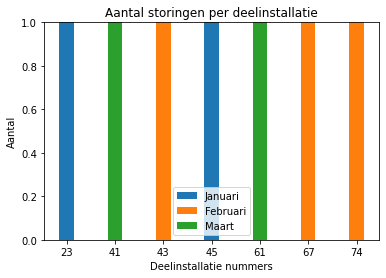

In [20]:
# plot
labels = list(new_dictionary.keys())
width = 0.3

fig, axis = plt.subplots()

prev = []
for l in range(len(lol)):
    month = sa._month_num_to_name([l+1])

    # added case for loop l = 0 after if
    axis.bar(labels, lol[l], width, label=month, bottom=prev) if l > 0 else \
    axis.bar(labels, lol[l], width, label=month)
    
    # prev sets the height of the newly added values like above
    # the added list needs to be added to prev to get the correct height
    prev = [prev[idx] + lol[l][idx] for idx in range(len(lol[l]))] if l > 0 else lol[l]

axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal storingen per deelinstallatie")
axis.legend()

axis.margins(x=0.05, y=0.1)

plt.show()

{'Januari': 5, 'Februari': 10, 'Maart': 4}


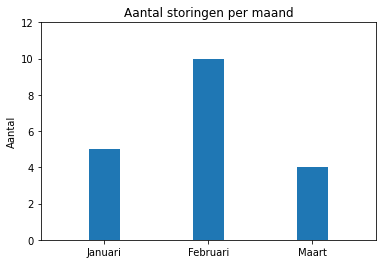

In [21]:
# prep
val_counts_months = df_s['month_number'].value_counts()

ordered_dict = {key: val_counts_months[key] for key in sorted(val_counts_months.to_dict())}

for key in ordered_dict.keys():
    new_key = sa._month_num_to_name([key])
    ordered_dict[new_key] = ordered_dict.pop(key)

print(ordered_dict)    
    
# plot
fig, axis = plt.subplots()
axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)
axis.set_ylabel('Aantal')
axis.set_title("Aantal storingen per maand")
axis.margins(x=.2, y=.2)
plt.show()

## Aantal onterechte meldingen per deelinstallatie

In [22]:
df_o = sa._isolate_notification_type(like_ntype='onterecht').copy()
# changing the di_numbers from '45-10' to '45'
new_num = []
for num in df_o['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

df_o.loc[:, 'sbs'] = new_num

In [23]:
# prep
sbs_grouped_df = df_o.copy().groupby(['sbs'])

"""
dictionary structure
{'23': {1: 1},
 '41': {1: 1},
 '43': {2: 1},
 '45': {2: 2, 1: 2},
 '46A': {2: 2},
 '61': {3: 1},
 '62': {1: 1},
 '63': {1: 1},
 '67': {2: 1},
 '74': {2: 1}}
"""
dictionary = {}
for group in sbs_grouped_df.groups.keys():
    df_group = sbs_grouped_df.get_group(group)
    month_counts = df_group['month_number'].value_counts().to_dict()
    if group in dictionary:
        for key in group.keys():
            if key in dictionary[group]:
                dictionary[group][key] += group[key]
            else:
                dictionary[group] = group[key]
    else:
        dictionary[group] = month_counts

"""
new_dictionary structure
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
new_dictionary = {}
for di_num in dictionary:
    list_of_lists = []
    for i in range(3):
        month_num = i + 1
        if month_num in dictionary[di_num].keys():
            list_of_lists.append(dictionary[di_num][month_num])
        else:
            list_of_lists.append(0)
    new_dictionary[di_num] = list_of_lists

"""
lol structure
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(3):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)

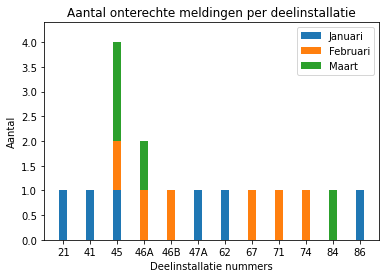

In [24]:
# plot
labels = list(new_dictionary.keys())
width = 0.3

fig, axis = plt.subplots()

prev = []
for l in range(len(lol)):
    month = sa._month_num_to_name([l+1])

    # added case for loop l = 0 after if
    axis.bar(labels, lol[l], width, label=month, bottom=prev) if l > 0 else \
    axis.bar(labels, lol[l], width, label=month)
    
    # prev sets the height of the newly added values like above
    # the added list needs to be added to prev to get the correct height
    prev = [prev[idx] + lol[l][idx] for idx in range(len(lol[l]))] if l > 0 else lol[l]

axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal onterechte meldingen per deelinstallatie")
axis.legend()

axis.margins(x=0.05, y=0.1)

plt.show()

{'Januari': 13, 'Februari': 16, 'Maart': 10}


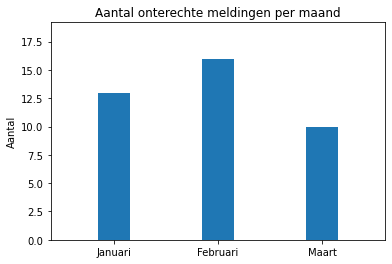

In [25]:
# prep
val_counts_months = df_o['month_number'].value_counts()

ordered_dict = {key: val_counts_months[key] for key in sorted(val_counts_months.to_dict())}

for key in ordered_dict.keys():
    new_key = sa._month_num_to_name([key])
    ordered_dict[new_key] = ordered_dict.pop(key)

print(ordered_dict)
    
# plot
fig, axis = plt.subplots()
axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)
axis.set_ylabel('Aantal')
axis.set_title("Aantal onterechte meldingen per maand")
axis.margins(x=.2, y=.2)
plt.show()

## Totaal aantal meldingen preventief per deelinstallatie

In [26]:
df_p = sa._isolate_notification_type(like_ntype='preventief').copy()
# changing the di_numbers from '45-10' to '45'
new_num = []
for num in df_p['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

df_p.loc[:, 'sbs'] = new_num

In [27]:
# prep
sbs_grouped_df = df_p.copy().groupby(['sbs'])

"""
dictionary structure
{'23': {1: 1},
 '41': {1: 1},
 '43': {2: 1},
 '45': {2: 2, 1: 2},
 '46A': {2: 2},
 '61': {3: 1},
 '62': {1: 1},
 '63': {1: 1},
 '67': {2: 1},
 '74': {2: 1}}
"""
dictionary = {}
for group in sbs_grouped_df.groups.keys():
    df_group = sbs_grouped_df.get_group(group)
    month_counts = df_group['month_number'].value_counts().to_dict()
    if group in dictionary:
        for key in group.keys():
            if key in dictionary[group]:
                dictionary[group][key] += group[key]
            else:
                dictionary[group] = group[key]
    else:
        dictionary[group] = month_counts

"""
new_dictionary structure
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
new_dictionary = {}
for di_num in dictionary:
    list_of_lists = []
    for i in range(3):
        month_num = i + 1
        if month_num in dictionary[di_num].keys():
            list_of_lists.append(dictionary[di_num][month_num])
        else:
            list_of_lists.append(0)
    new_dictionary[di_num] = list_of_lists

"""
lol structure
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(3):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)

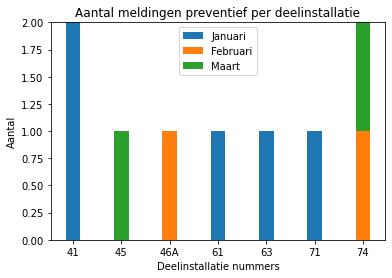

In [28]:
# plot
labels = list(new_dictionary.keys())
width = 0.3

fig, axis = plt.subplots()

prev = []
for l in range(len(lol)):
    month = sa._month_num_to_name([l+1])

    # added case for loop l = 0 after if
    axis.bar(labels, lol[l], width, label=month, bottom=prev) if l > 0 else \
    axis.bar(labels, lol[l], width, label=month)
    
    # prev sets the height of the newly added values like above
    # the added list needs to be added to prev to get the correct height
    prev = [prev[idx] + lol[l][idx] for idx in range(len(lol[l]))] if l > 0 else lol[l]


axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen preventief per deelinstallatie")
axis.legend()

axis.margins(x=0.05, y=0.1)

plt.show()

{'Januari': 9, 'Februari': 6, 'Maart': 3}


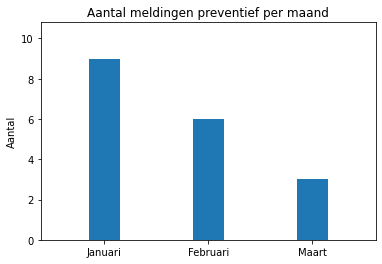

In [29]:
# prep
val_counts_months = df_p['month_number'].value_counts()

ordered_dict = {key: val_counts_months[key] for key in sorted(val_counts_months.to_dict())}

for key in ordered_dict.keys():
    new_key = sa._month_num_to_name([key])
    ordered_dict[new_key] = ordered_dict.pop(key)

print(ordered_dict)
    
# plot
fig, axis = plt.subplots()
axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)
axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen preventief per maand")
axis.margins(x=.2, y=.2)
plt.show()

## Aantal incidenten per deelinstallatie

In [30]:
df_i = sa._isolate_notification_type(like_ntype='incident').copy()
# changing the di_numbers from '45-10' to '45'
new_num = []
for num in df_i['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

df_i.loc[:, 'sbs'] = new_num

In [31]:
# prep
sbs_grouped_df = df_i.copy().groupby(['sbs'])

"""
dictionary structure (result of code below)
{'23': {1: 1},  # {month_num: notifications}
 '41': {1: 1},
 '43': {2: 1},
 '45': {2: 2, 1: 2},
 '46A': {2: 2},
 '61': {3: 1},
 '62': {1: 1},
 '63': {1: 1},
 '67': {2: 1},
 '74': {2: 1}}
"""
dictionary = {}
for group in sbs_grouped_df.groups.keys():
    df_group = sbs_grouped_df.get_group(group)
    month_counts = df_group['month_number'].value_counts().to_dict()
    if group in dictionary:
        for key in group.keys():
            if key in dictionary[group]:
                dictionary[group][key] += group[key]
            else:
                dictionary[group] = group[key]
    else:
        dictionary[group] = month_counts

"""
new_dictionary structure (result of code below)
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
new_dictionary = {}
for di_num in dictionary:
    list_of_lists = []
    for i in range(3):
        month_num = i + 1
        if month_num in dictionary[di_num].keys():
            list_of_lists.append(dictionary[di_num][month_num])
        else:
            list_of_lists.append(0)
    new_dictionary[di_num] = list_of_lists

"""
lol structure (result of code below)
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(3):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)

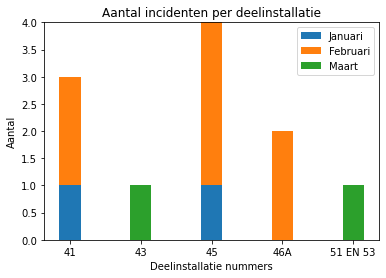

In [32]:
# plot
labels = list(new_dictionary.keys())
width = 0.3

fig, axis = plt.subplots()

prev = []
for l in range(len(lol)):
    month = sa._month_num_to_name([l+1])

    # added case for loop l = 0 after if
    axis.bar(labels, lol[l], width, label=month, bottom=prev) if l > 0 else \
    axis.bar(labels, lol[l], width, label=month)
    
    # prev sets the height of the newly added values like above
    # the added list needs to be added to prev to get the correct height
    prev = [prev[idx] + lol[l][idx] for idx in range(len(lol[l]))] if l > 0 else lol[l]


axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal incidenten per deelinstallatie")
axis.legend()

axis.margins(x=0.05, y=0.1)

plt.show()

{'Januari': 3, 'Februari': 13, 'Maart': 7}


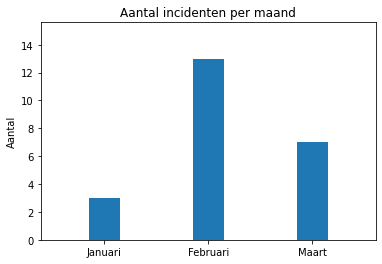

In [33]:
# prep
val_counts_months = df_i['month_number'].value_counts()

ordered_dict = {key: val_counts_months[key] for key in sorted(val_counts_months.to_dict())}

for key in ordered_dict.keys():
    new_key = sa._month_num_to_name([key])
    ordered_dict[new_key] = ordered_dict.pop(key)

print(ordered_dict)    
    
# plot
fig, axis = plt.subplots()
axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)
axis.set_ylabel('Aantal')
axis.set_title("Aantal incidenten per maand")
axis.margins(x=.2, y=.2)
plt.show()

# Combineren van de historische data met de staging file.

In [34]:
x = sa.meldingen.copy()
histo_meldingen = sa.metadata.meldingen()
# datum wordt een input veld
input_start_date = datetime(2021, 4, 1)

new_num = []
for num in x['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

x.loc[:, 'sbs'] = new_num

x = x.groupby(['month_number'])

"""
De meldingen zonder di_num worden vooralsnog (12-7-2021) niet meegenomen in de historische data. De meldingen zonder di
zijn in sommige gevallen de meldingen die het meest voorkomen.
"""
new_hist = {}
for group in x.groups:
    dff = x.get_group(group)
    vc = dff['sbs'].value_counts().to_dict()
    key = f'0{group}_{input_start_date.year}' if group < 10 else f'{group}_{input_start_date.year}'
    new_hist[key] = dff['sbs'].value_counts().to_dict()
    

# dev_case had historical data up until 03_2021, so TypeError because of overlapping keys Q1 for 2021
# updated_histo = dict(**histo_meldingen, **new_hist)
updated_histo = dict(**histo_meldingen)

# Vervolg grafieken

## Vergelijking Qx met alle voorgaande Qx

In [35]:
months_to_exclude = [sa.metadata._quarters[q][i] for q in sa.metadata._quarters.keys() if q != 'Q1' for i in range(len(sa.metadata._quarters[q]))]
print(f'Months to exclude in function get_month_list: {months_to_exclude}')
month_list = sa.metadata.get_month_list(exclude_month=months_to_exclude)
ordered_month_list = sa.metadata.order_month_list_by_year(month_list=month_list)
ordered_month_list

Months to exclude in function get_month_list: ['04', '05', '06', '07', '08', '09', '10', '11', '12']


{'2016': ['01_2016', '02_2016', '03_2016'],
 '2017': ['01_2017', '02_2017', '03_2017'],
 '2018': ['01_2018', '02_2018', '03_2018'],
 '2019': ['01_2019', '02_2019', '03_2019'],
 '2020': ['01_2020', '02_2020', '03_2020'],
 '2021': ['01_2021', '02_2021', '03_2021']}

Neem de ordered dict en verzamel de som van de meldingen per maand en som die per jaar op. result is een dict met structuur
```
{q1_jaar1: aantal meldingen,
 ... : ... ,
 q1_jaarn: aantal meldingen}
```

In [123]:
notifications_per_quarter = {}
for key in ordered_month_list.keys():
    summed_vals = sa.metadata.sum_values(dictionary=updated_histo, keys=ordered_month_list[key])
    notifications_per_quarter[key] = summed_vals

notifications_per_quarter

{'2016': 184, '2017': 122, '2018': 100, '2019': 71, '2020': 60, '2021': 158}

### Alternatieve werkwijze
Met het toepassen van de module self.filter_dictionary_keys().

werkwijze van hiervoor verzameld eerst het aantal meldingen per kwartaal en dan meldingen per deelinstallatie per kwartaal.

onderstaande werkwijze verzameld eerst het aantal meldingen per di per kwartaal en dan het aantal meldingen per kwartaal.

In [143]:
filtered_meldingen_dict = {}
for key in ordered_month_list.keys():
    filtered_meldingen = sa.metadata.filter_dictionary_keys(dictionary=updated_histo, keys=ordered_month_list[key])
#     filtered_meldingen_dict = dict(**filtered_meldingen_dict, **filtered_meldingen)
    filtered_meldingen_dict[key] = filtered_meldingen
    
# filtered_meldingen_dict

## Vervolg Vergelijking Qx met alle voorgaande Qx

In [145]:
melding_per_q_dict = {}
for year in filtered_meldingen_dict:  # keys als '2016', '2021'
    if year not in melding_per_q_dict.keys():  # add key to new dict
        melding_per_q_dict[year] = {}
    
    for d in filtered_meldingen_dict[year]:  # keys als '01_2016', '02_2016'
        for di in filtered_meldingen_dict[year][d]:  # keys als di_nummers '45', '61'
            if di not in melding_per_q_dict[year].keys():
                melding_per_q_dict[year][di] = filtered_meldingen_dict[year][d][di]
            else:
                melding_per_q_dict[year][di] += filtered_meldingen_dict[year][d][di]
                
# melding_per_q_dict  # wordt gebruikt om bars van bar plot naast elkaar te plotten !!!! 

In [135]:
# switching level 1 and level 2 keys
present_di_numbers = sa.metadata.contract_info()['aanwezige_deelinstallaties']

new_dict = {x: {} for x in sorted(present_di_numbers)}

for lvl1_key in melding_per_q_dict.keys():
    
    for lvl2_key in melding_per_q_dict[lvl1_key].keys():

        val = melding_per_q_dict[lvl1_key][lvl2_key]
        new_dict[lvl2_key][lvl1_key] = val

new_dict

{'0': {'2016': 7, '2017': 8, '2018': 12, '2019': 3, '2020': 8, '2021': 25},
 '10': {'2021': 2},
 '11': {'2017': 1},
 '12': {'2016': 1},
 '13': {},
 '14': {},
 '15': {'2016': 12, '2017': 1, '2019': 2, '2021': 5},
 '16': {'2021': 1},
 '17': {'2020': 2, '2021': 4},
 '20': {'2021': 1},
 '21': {'2016': 2, '2018': 1, '2020': 1, '2021': 3},
 '22': {},
 '23': {'2016': 14, '2018': 8, '2019': 2, '2021': 29},
 '24': {'2016': 3, '2017': 1, '2019': 1, '2021': 3},
 '25 EN 26': {'2019': 2, '2021': 2},
 '28': {'2021': 3},
 '30': {'2017': 1, '2019': 6, '2020': 3, '2021': 3},
 '35': {},
 '36': {'2016': 2, '2021': 2},
 '37': {'2019': 1},
 '38': {'2017': 1, '2018': 5, '2020': 2, '2021': 1},
 '39': {'2017': 1, '2020': 2},
 '40': {'2016': 1},
 '41': {'2016': 11, '2017': 8, '2018': 8, '2019': 5, '2020': 1, '2021': 4},
 '42': {'2020': 1},
 '43': {'2016': 17, '2017': 7, '2018': 10, '2019': 6, '2020': 3, '2021': 8},
 '44': {'2016': 9, '2017': 1, '2019': 2},
 '45': {'2016': 35, '2017': 25, '2018': 11, '2019': 7,

In [136]:
"""
new_dictionary structure (result of code below)
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
new_dictionary = {}
for di_num in new_dict:  # new_dict is van vorig coce block
    list_of_lists = []
    for jaar in melding_per_q_dict.keys():

        if jaar in new_dict[di_num].keys():
            list_of_lists.append(new_dict[di_num][jaar])
            
        else:
            list_of_lists.append(0)
            
    new_dictionary[di_num] = list_of_lists

"""
lol structure (result of code below)
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(len(melding_per_q_dict.keys())):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)  

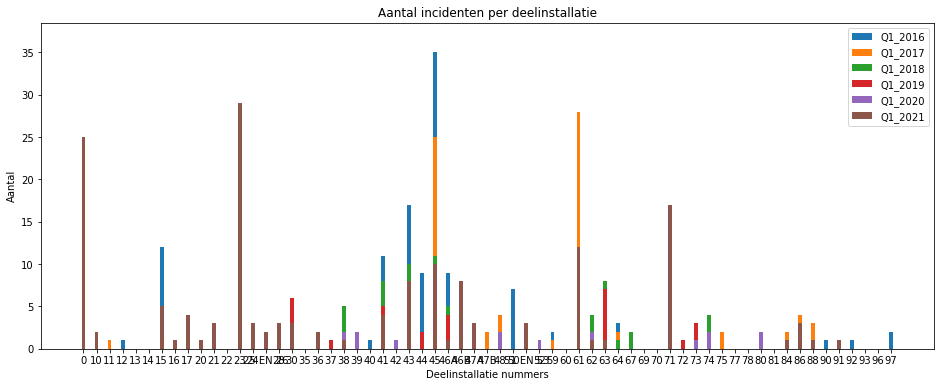

In [137]:
# plot
labels = list(new_dictionary.keys())
width = 0.3

fig, axis = plt.subplots(figsize=(16, 6))

color_label = [f'Q1_{x}' for x in list(melding_per_q_dict.keys())]

# De waarden worden hier wss nog over elkaar heen gepresenteerd. Zoek naar een manier om dit naar elkaar te doen 
# of bouw dit blok om naar de opstapeling. 
for l in range(len(lol)):
    axis.bar(labels, lol[l], width, label=color_label[l])

axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal incidenten per deelinstallatie")
axis.legend()

axis.margins(x=0.05, y=0.1)

plt.show()

Onderstaand stuk richt zich op een andere presentatie dan bovenstaande grafiek. In de volgende grafiek is het de bedoeling dat de data van elke di naast elkaar gepresenteerd worden. 

melding_per_q_dict heeft voor het grootste deel de juiste structuur. Moet wel nog omgevormd worden naar een lijst van lijsten, waarbij elke lijst een jaar representeerd. (van dict of dicts naar list of lists)

In [148]:
source = new_dict.copy()
source = {key: source[key] for key in source.keys() if len(source[key]) > 0}
source

{'0': {'2016': 7, '2017': 8, '2018': 12, '2019': 3, '2020': 8, '2021': 25},
 '10': {'2021': 2},
 '11': {'2017': 1},
 '12': {'2016': 1},
 '15': {'2016': 12, '2017': 1, '2019': 2, '2021': 5},
 '16': {'2021': 1},
 '17': {'2020': 2, '2021': 4},
 '20': {'2021': 1},
 '21': {'2016': 2, '2018': 1, '2020': 1, '2021': 3},
 '23': {'2016': 14, '2018': 8, '2019': 2, '2021': 29},
 '24': {'2016': 3, '2017': 1, '2019': 1, '2021': 3},
 '25 EN 26': {'2019': 2, '2021': 2},
 '28': {'2021': 3},
 '30': {'2017': 1, '2019': 6, '2020': 3, '2021': 3},
 '36': {'2016': 2, '2021': 2},
 '37': {'2019': 1},
 '38': {'2017': 1, '2018': 5, '2020': 2, '2021': 1},
 '39': {'2017': 1, '2020': 2},
 '40': {'2016': 1},
 '41': {'2016': 11, '2017': 8, '2018': 8, '2019': 5, '2020': 1, '2021': 4},
 '42': {'2020': 1},
 '43': {'2016': 17, '2017': 7, '2018': 10, '2019': 6, '2020': 3, '2021': 8},
 '44': {'2016': 9, '2017': 1, '2019': 2},
 '45': {'2016': 35, '2017': 25, '2018': 11, '2019': 7, '2020': 7, '2021': 10},
 '46A': {'2016': 9,

In [157]:
"""
new_dictionary structure (result of code below)
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
jaren = list(melding_per_q_dict.keys())

new_dictionary = {}

for di_num in new_dict:
    list_of_lists = []
    for i in range(len(jaren)):  
        jaar = jaren[i]
        if jaar in new_dict[di_num].keys():
            list_of_lists.append(new_dict[di_num][jaar])
        else:
            list_of_lists.append(0)
    new_dictionary[di_num] = list_of_lists

"""
lol structure (result of code below)
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(len(jaren)):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)

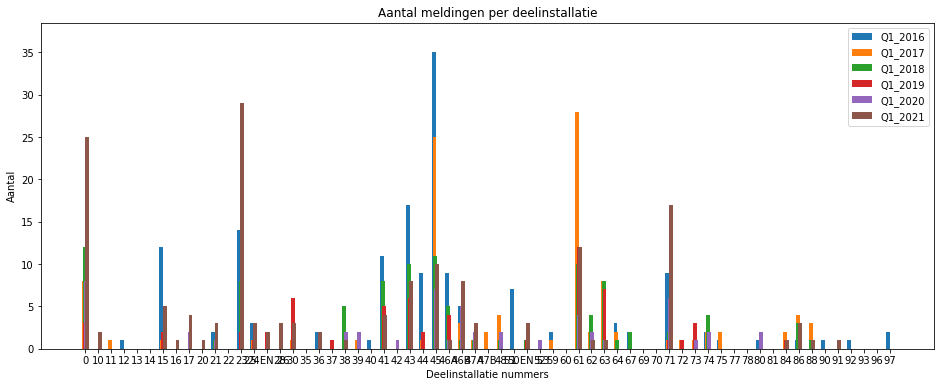

In [235]:
# plot
labels = list(new_dictionary.keys())
x = np.arange(len(labels))  # the x locations of the labels

data = lol.copy()

width = 0.3  # of the bars

fig, axis = plt.subplots(figsize=(16, 6))

color_labels = [f'Q1_{x}' for x in list(melding_per_q_dict.keys())]

# voor het bepalen van de afstand vanaf x zodat de bars niet overlappen
x_generator = (x + (y * (width / len(jaren))) for y in range(-3, 4))  

for _ in range(len(data)):
    axis.bar(x=next(x_generator),height=data[_], width=width, label=color_labels[_])

# # De waarden worden hier wss nog over elkaar heen gepresenteerd. Zoek naar een manier om dit naar elkaar te doen 
# # of bouw dit blok om naar de opstapeling. 
# for l in range(len(lol)):
#     axis.bar(labels, lol[l], width, label=color_label[l])

axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen per deelinstallatie")

axis.set_xticks(x)
axis.set_xticklabels(labels)

axis.legend()

axis.margins(x=0.05, y=0.1)

plt.show()

Onderstaande is voor het presenteren van het totale aantal meldingen per kwartaal

In [138]:
notifications_per_quarter_2 = {}
for key in ordered_month_list.keys():
    summed_vals = sa.metadata.sum_values(dictionary=filtered_meldingen_dict[key])
    notifications_per_quarter_2[key] = summed_vals
    
notifications_per_quarter_2

{'2016': 184, '2017': 122, '2018': 100, '2019': 71, '2020': 60, '2021': 158}

dict_keys(['2016', '2017', '2018', '2019', '2020', '2021'])
{'Q1_2016': 184, 'Q1_2017': 122, 'Q1_2018': 100, 'Q1_2019': 71, 'Q1_2020': 60, 'Q1_2021': 158}


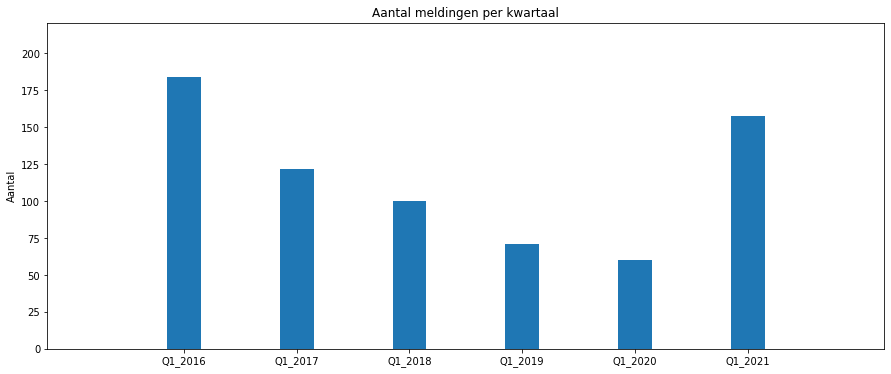

In [139]:
# prep
print(notifications_per_quarter.keys())
val_counts_quarter = notifications_per_quarter

ordered_dict = {}
for key in val_counts_quarter.keys():
    new_key = f'Q1_{key}'
    ordered_dict[new_key] = val_counts_quarter[key]

print(ordered_dict) 

# plot
fig, axis = plt.subplots(figsize=(15,6))
axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)
axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen per kwartaal")
axis.margins(x=.2, y=.2)
plt.show()